# Test - prey 4 - CompetitiveGrid 
Target speed

In [2]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import explorationlib
from explorationlib.agent import DiffusionGrid

from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values
from explorationlib.local_gym import CompetitiveGrid

from explorationlib.run import multi_experiment
from explorationlib.util import select_exp
from explorationlib.util import select_agent
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_positions2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import show_gif

from explorationlib import score
from explorationlib.score import num_death
from explorationlib.score import average_reward
from explorationlib.score import total_reward
from explorationlib.score import first_reward

In [3]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Uncomment for local development
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

# 10 pred, 10 preys
Search prey/target speed

## Shared env and params

In [4]:
# How long to run? Longer is better, but slower.
num_steps = 100
num_experiments = 100

num_agents = 20
num_targets = 10
target_index = list(range(0, num_targets))

detection_radius = 1
p_target = 1.0
target_boundary = (10, 10)

step_size = 1
min_length = 1
detection_radius =  1
scale = 1

# Create env 
env = CompetitiveGrid(num_agents=num_agents, mode=None)
targets = uniform_targets(num_targets, target_boundary)
values = constant_values(targets, 1.0)

<IPython.core.display.Javascript object>

In [5]:
targets

[array([-9.08450691,  0.33659907]),
 array([-5.74674572, -0.47527808]),
 array([1.106866  , 7.69231247]),
 array([-2.47251036,  7.54633774]),
 array([-5.41152519, -4.85428708]),
 array([8.59130529, 7.00984077]),
 array([-6.61348354, -9.21485929]),
 array([9.17988842, 3.0387091 ]),
 array([ 7.37059446, -5.38892798]),
 array([7.05881742, 6.44076514])]

<IPython.core.display.Javascript object>

In [6]:
num_targets

10

<IPython.core.display.Javascript object>

In [7]:
print(f"Target index : {target_index}")

Target index : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


<IPython.core.display.Javascript object>

## Run

In [8]:
target_step_sizes = [1, 2, 3]
colors = ["darkgreen", "seagreen", "cadetblue"]
names = list(range(3))

# !
results = []
for name, target_step_size in zip(names, target_step_sizes):
    # Intial targets
    env.add_targets(
        target_index, 
        targets, 
        values, 
        detection_radius=detection_radius, 
        p_target=p_target
    )

    # Preds
    preds = [DiffusionGrid(
            scale=scale, 
            min_length=min_length, 
            step_size=step_size
    )] * (num_agents - num_targets)

    # Preys
    preys = [
        DiffusionGrid(
            scale=scale, 
            min_length=min_length, 
            step_size=target_step_size,
        )] * num_targets

    # All agents
    agents = preys + preds

    # !
    comp_exp = multi_experiment(
        f"test_{name}",
        agents, 
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        seed=404,
        split_state=False,
        dump=False
    )
    results.append(comp_exp)

test_2: 100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


<IPython.core.display.Javascript object>

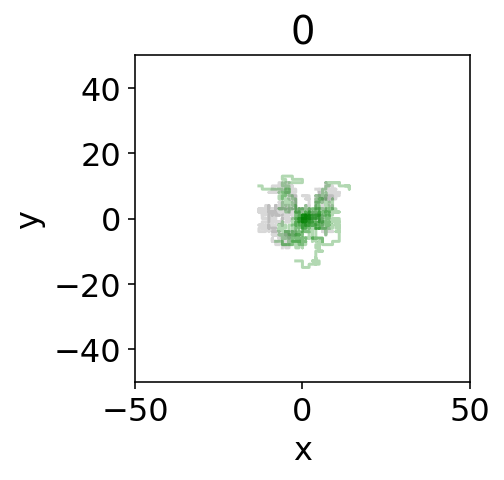

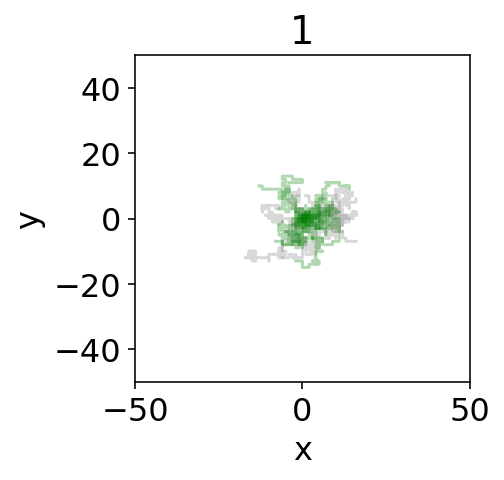

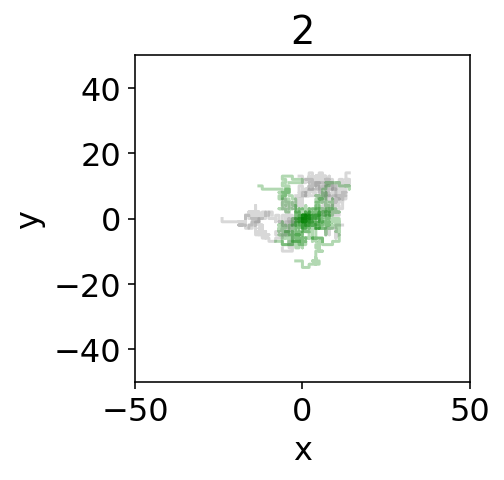

<IPython.core.display.Javascript object>

In [17]:
num_experiment = 50
plot_boundary = (50, 50)

for name, exp in zip(names, results):
    # Example bout
    ax = None
    ax = plot_positions2d(
        select_exp(exp, num_experiment),
        num_agents,
        boundary=plot_boundary,
        colors=["grey"] * num_targets + ["green"] * (num_agents - num_targets),
        alpha=0.3,
        figsize=(3, 3),
        title=name
    )

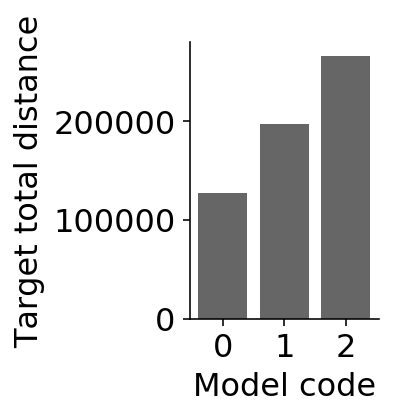

<IPython.core.display.Javascript object>

In [18]:
# Results
num_agent = 0
scores = []
for i, result, color in zip(names, results, colors):
    l = 0.0
    for r in result:
        l += r["agent_history"][num_agent]["agent_total_l"][-1]
    scores.append(l)   

# Tabulate
m, sd = [], []
for s in zip(scores):
    m.append(np.mean(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Target total distance")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

In [19]:
names

[0, 1, 2]

<IPython.core.display.Javascript object>

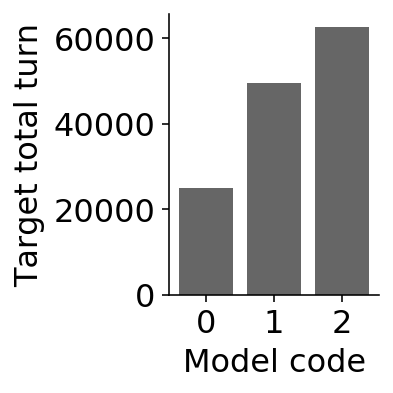

<IPython.core.display.Javascript object>

In [20]:
# Results
num_agent = 0
scores = []
for i, result, color in zip(names, results, colors):
    l = 0.0
    for r in result:
        l += r["agent_history"][num_agent]["agent_num_turn"][-1]
    scores.append(l)   

# Tabulate
m, sd = [], []
for s in zip(scores):
    m.append(np.mean(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Target total turn")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

num_death: 100%|██████████| 100/100 [00:00<00:00, 3527.17it/s]


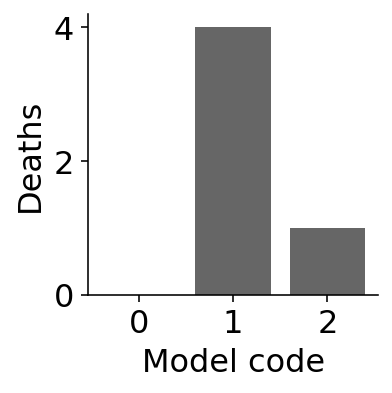

<IPython.core.display.Javascript object>

In [21]:
scores = []
for i, result, color in zip(names, results, colors):
    scores.append(num_death(result))   

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

total_reward: 100%|██████████| 100/100 [00:00<00:00, 3004.17it/s]


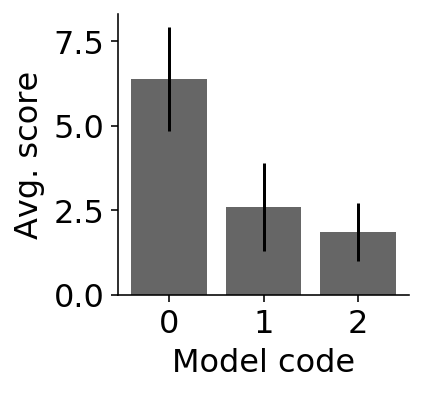

<IPython.core.display.Javascript object>

In [22]:
# Results
scores = []
for i, result, color in zip(names, results, colors):    
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m, sd = [], []
for s in zip(scores):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

total_reward: 100%|██████████| 100/100 [00:00<00:00, 12423.89it/s]


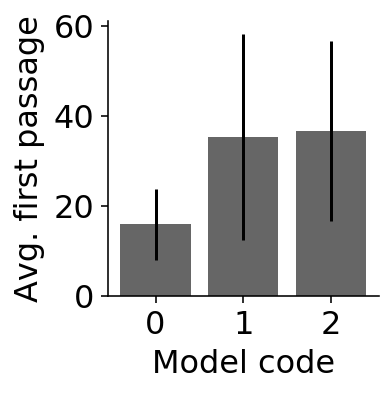

<IPython.core.display.Javascript object>

In [23]:
# Results
scores = []
for i, result, color in zip(names, results, colors):    
    r = first_reward(result)
    scores.append(r)   

# Tabulate
m, sd = [], []
for s in zip(scores):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. first passage")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()